# Nested ANOVA - one between factor
Reference: http://www.flutterbys.com.au/stats/tut/tut9.2b.html

In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data loading

In [2]:
#curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies = pd.read_csv('../datasets/curdies.csv')
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [3]:
labels_SITE = ['{}{}'.format(curdies['SITE'][i], curdies['SEASON'][j][0]) for i, j in zip(curdies['SITE'].index, curdies['SEASON'].index)]
labels_SITE = sorted(list(set(labels_SITE)))
labels_SITE

['1W', '2W', '3W', '4S', '5S', '6S']

In [4]:
#curdies.dropna(axis=0, inplace=True)
#curdies.reset_index(inplace=True)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [5]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies.head(10)

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1W,0.647683,0.897100
1,WINTER,1W,6.096152,1.571317
2,WINTER,1W,1.310564,1.069953
3,WINTER,1W,1.725279,1.146080
4,WINTER,1W,1.459387,1.099114
5,WINTER,1W,1.057561,1.014090
6,WINTER,2W,1.016298,1.004050
7,WINTER,2W,16.196794,2.006122
8,WINTER,2W,1.168081,1.039605
9,WINTER,2W,1.024299,1.006020


In [6]:
curdies_agg = curdies.groupby(by=['SEASON', 'SITE'], as_index=False).mean()
curdies_agg.dropna(axis=0, inplace=True)
curdies_agg.reset_index(inplace=True)
curdies_agg

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,2.049437,1.132942
1,1,WINTER,2W,4.181908,1.271870
2,2,WINTER,3W,0.678206,0.867871
3,9,SUMMER,4S,0.419095,0.350821
4,10,SUMMER,5S,0.229086,0.180462
5,11,SUMMER,6S,0.194244,0.381122


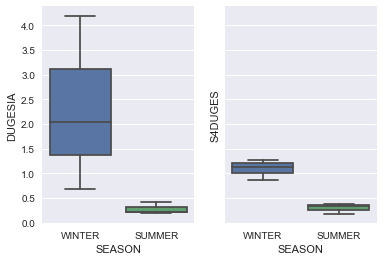

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

## Fit hierarchical model
I will use the matrix parametrization

In [42]:
#X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
#X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [43]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)

In [44]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.       , 0.       , 0.9849349, 0.       , 0.       , 1.1199931,
       1.0827734, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.6037669, 0.       , 0.9006648, 0.7823021])

In [59]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=3000, chains=2, step=pm.NUTS(), njobs=2, tune=2000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


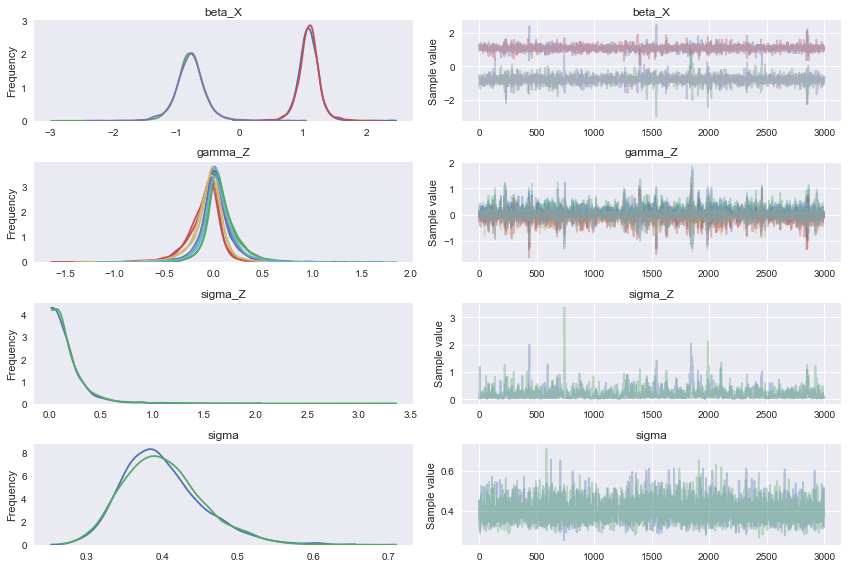

In [60]:
_ = pm.traceplot(trace)

In [61]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.091750,0.177379,0.004132,0.758612,1.437852,1614.0,0.999889
beta_X__1,-0.788316,0.258883,0.006696,-1.268749,-0.275502,1558.0,0.999866
gamma_Z__0,0.018265,0.170086,0.003774,-0.297949,0.378655,1763.0,1.000076
gamma_Z__1,0.080617,0.180227,0.004514,-0.253227,0.457710,1552.0,0.999990
gamma_Z__2,-0.100489,0.182505,0.004682,-0.472673,0.228295,1494.0,0.999833
gamma_Z__3,0.021815,0.188908,0.003687,-0.338303,0.407982,2739.0,0.999851
gamma_Z__4,-0.056206,0.185085,0.003811,-0.461764,0.259418,2265.0,0.999907
gamma_Z__5,0.034347,0.186833,0.003619,-0.285895,0.453982,2525.0,0.999860
sigma_Z,0.191815,0.183217,0.007154,0.018058,0.510875,618.0,1.000265
sigma,0.401117,0.053073,0.000856,0.305784,0.510104,3689.0,1.000017


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000200D72BCE10>,
      dtype=object)

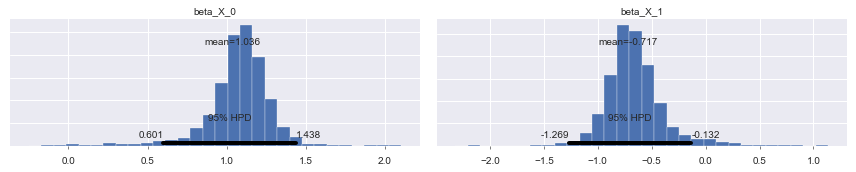

In [14]:
pm.plot_posterior(trace, varnames=['beta_X'])

The `beta_X` seems to be close enough

In [15]:
curdies.groupby(['SEASON'])[['S4DUGES']].mean()

,S4DUGES
SEASON,
WINTER,1.090894
SUMMER,0.304135


The `sigma` seems to be ok

In [16]:
curdies.groupby(['SEASON'])['S4DUGES'].std().mean()

0.3847746117705029

In [17]:
mcmc_X = trace['beta_X']

In [18]:
fit_X = np.dot(np.asarray(mcmc_X), X.T)

In [19]:
fit_X.mean(axis=0)

array([1.03584983, 1.03584983, 1.03584983, 1.03584983, 1.03584983,
       1.03584983, 1.03584983, 1.03584983, 1.03584983, 1.03584983,
       1.03584983, 1.03584983, 1.03584983, 1.03584983, 1.03584983,
       1.03584983, 1.03584983, 1.03584983, 0.31851573, 0.31851573,
       0.31851573, 0.31851573, 0.31851573, 0.31851573, 0.31851573,
       0.31851573, 0.31851573, 0.31851573, 0.31851573, 0.31851573,
       0.31851573, 0.31851573, 0.31851573, 0.31851573, 0.31851573,
       0.31851573])

In [20]:
mcmc_Z = trace['gamma_Z']

In [21]:
fit_Z = np.dot(np.asarray(mcmc_Z), Z.T)

In [22]:
fit_Z.mean(axis=0)

array([ 0.05914825,  0.05914825,  0.05914825,  0.05914825,  0.05914825,
        0.05914825,  0.12431916,  0.12431916,  0.12431916,  0.12431916,
        0.12431916,  0.12431916, -0.06300868, -0.06300868, -0.06300868,
       -0.06300868, -0.06300868, -0.06300868,  0.01446043,  0.01446043,
        0.01446043,  0.01446043,  0.01446043,  0.01446043, -0.0650401 ,
       -0.0650401 , -0.0650401 , -0.0650401 , -0.0650401 , -0.0650401 ,
        0.02730719,  0.02730719,  0.02730719,  0.02730719,  0.02730719,
        0.02730719])

In [23]:
fit = fit_X + fit_Z

In [24]:
curdies['S4DUGES_FIT'] = fit.mean(axis=0)

In [25]:
curdies

,SEASON,SITE,DUGESIA,S4DUGES,S4DUGES_FIT
0,WINTER,1W,0.647683,0.897100,1.094998
1,WINTER,1W,6.096152,1.571317,1.094998
2,WINTER,1W,1.310564,1.069953,1.094998
3,WINTER,1W,1.725279,1.146080,1.094998
4,WINTER,1W,1.459387,1.099114,1.094998
5,WINTER,1W,1.057561,1.014090,1.094998
6,WINTER,2W,1.016298,1.004050,1.160169
7,WINTER,2W,16.196794,2.006122,1.160169
8,WINTER,2W,1.168081,1.039605,1.160169
9,WINTER,2W,1.024299,1.006020,1.160169


## Alternative parametrization (hierarchical)

In [62]:
X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
X = np.asarray(X)
X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [63]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=estimate_X, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=3000, chains=2, step=pm.NUTS(), njobs=2, tune=1000)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 635 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6159806152992681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 375 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7125459416831629, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


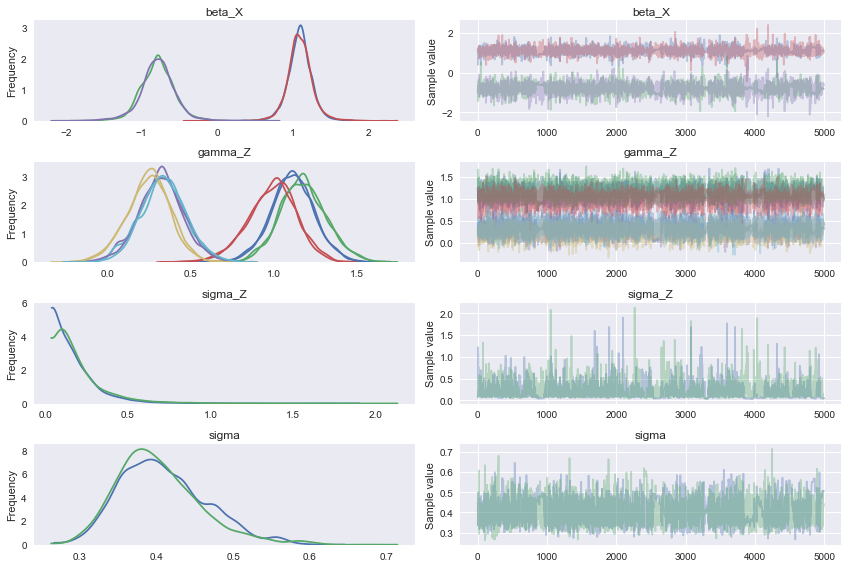

In [64]:
_ = pm.traceplot(trace)

In [65]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.095075,0.167181,0.003841,0.774906,1.431412,1920.0,0.999927
beta_X__1,-0.793262,0.234417,0.005499,-1.276184,-0.336436,1466.0,0.999911
gamma_Z__0,1.112333,0.132292,0.003252,0.835740,1.366998,1317.0,0.999900
gamma_Z__1,1.177520,0.139719,0.004055,0.891070,1.447657,833.0,1.000234
gamma_Z__2,0.989820,0.147390,0.004245,0.693929,1.278664,688.0,1.001238
gamma_Z__3,0.323691,0.135547,0.002877,0.048340,0.589043,1490.0,1.000562
gamma_Z__4,0.246664,0.133413,0.002836,-0.019092,0.507834,1475.0,0.999918
gamma_Z__5,0.335356,0.137468,0.003363,0.043625,0.591334,1171.0,1.000389
sigma_Z,0.192954,0.162381,0.005004,0.034629,0.483563,555.0,1.004829
sigma,0.405698,0.056154,0.001954,0.309225,0.522765,499.0,1.004552
